# IMA204 Practical Session - Segmentation of medical images



## ADD your name(s) here: <br>

DUPUIS Benjamin

I chose to work on the **segmentation of the left ventricle**

In [ ]:
# If needed, install the necessary packages
install_packages = False
if install_packages:
    !pip install numpy matplotlib scipy scikit-image scikit-learn opencv-python tqdm

In [129]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
import scipy
from scipy.io import loadmat
from scipy.interpolate import splprep, splev

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian
from skimage.draw import polygon


# For Kmeans
import cv2 


# PRINT VERSIONS
#print("os.__version__",os.__version__)
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("scipy.__version__",scipy.__version__)
print("cv2.__version__",cv2.__version__)
#print("glob.__version__",glob.__version__)


np.__version__ 2.2.2
matplotlib.__version__ 3.10.0
skimage.__version__ 0.25.1
scipy.__version__ 1.15.1
cv2.__version__ 4.11.0



# ASSIGNMENT DETAILS:

__Overall task:__ <br> 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure(s) of interest**. For the postprocessing you can rely on extraction of connected components and apply some criteria (size, shape, position,..) to extract the component(s) that most likely correspond(s) to the structure(s) of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* __Cropping__ the field of view to remove the background (a common issue in medical images)
* Target a __range of intensity values__ based on learning from the gt masks and corresponding images you are given. 
* Learn __priors on shape/intensity statistics__ from the provided gt masks


## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment __TWO EXAMPLES__ from a single use-case. You must print in the report that code which was  run over the two cases. We need to see in your code that your were able to run the same pipeline on two cases without changing any hyperparameter or changing them based on image-specific information. So comment the code and list all hyperparameter values clearly at the start of the cell. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>
<br>
* __Extra point(s) if__ :
    1. you provide results on more use-cases or more than 2 examples per use case. <br>
    2. you test your segmentation pipeline on images degraded by noise for example. <br>


### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

# Visualization and analysis of the data

Before starting the segmentation, we will first visualize the data and the ground truth to understand the problem and the data we are working with.

In [130]:
# Load Data MRI Heart
MRIheart_path = './data/MRIheart/'
os.listdir(MRIheart_path)

data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

In [131]:
# Let's view the first 5 segmentations
for i in range(5):
    print(seg[0, 5])

[[-99999]]
[[-99999]]
[[-99999]]
[[-99999]]
[[-99999]]


this is weird, it seems a lot of frames do not have a ground truth (and -99999 instead ?). Let's visualize them.

(11, 20)
(256, 256, 11, 20)


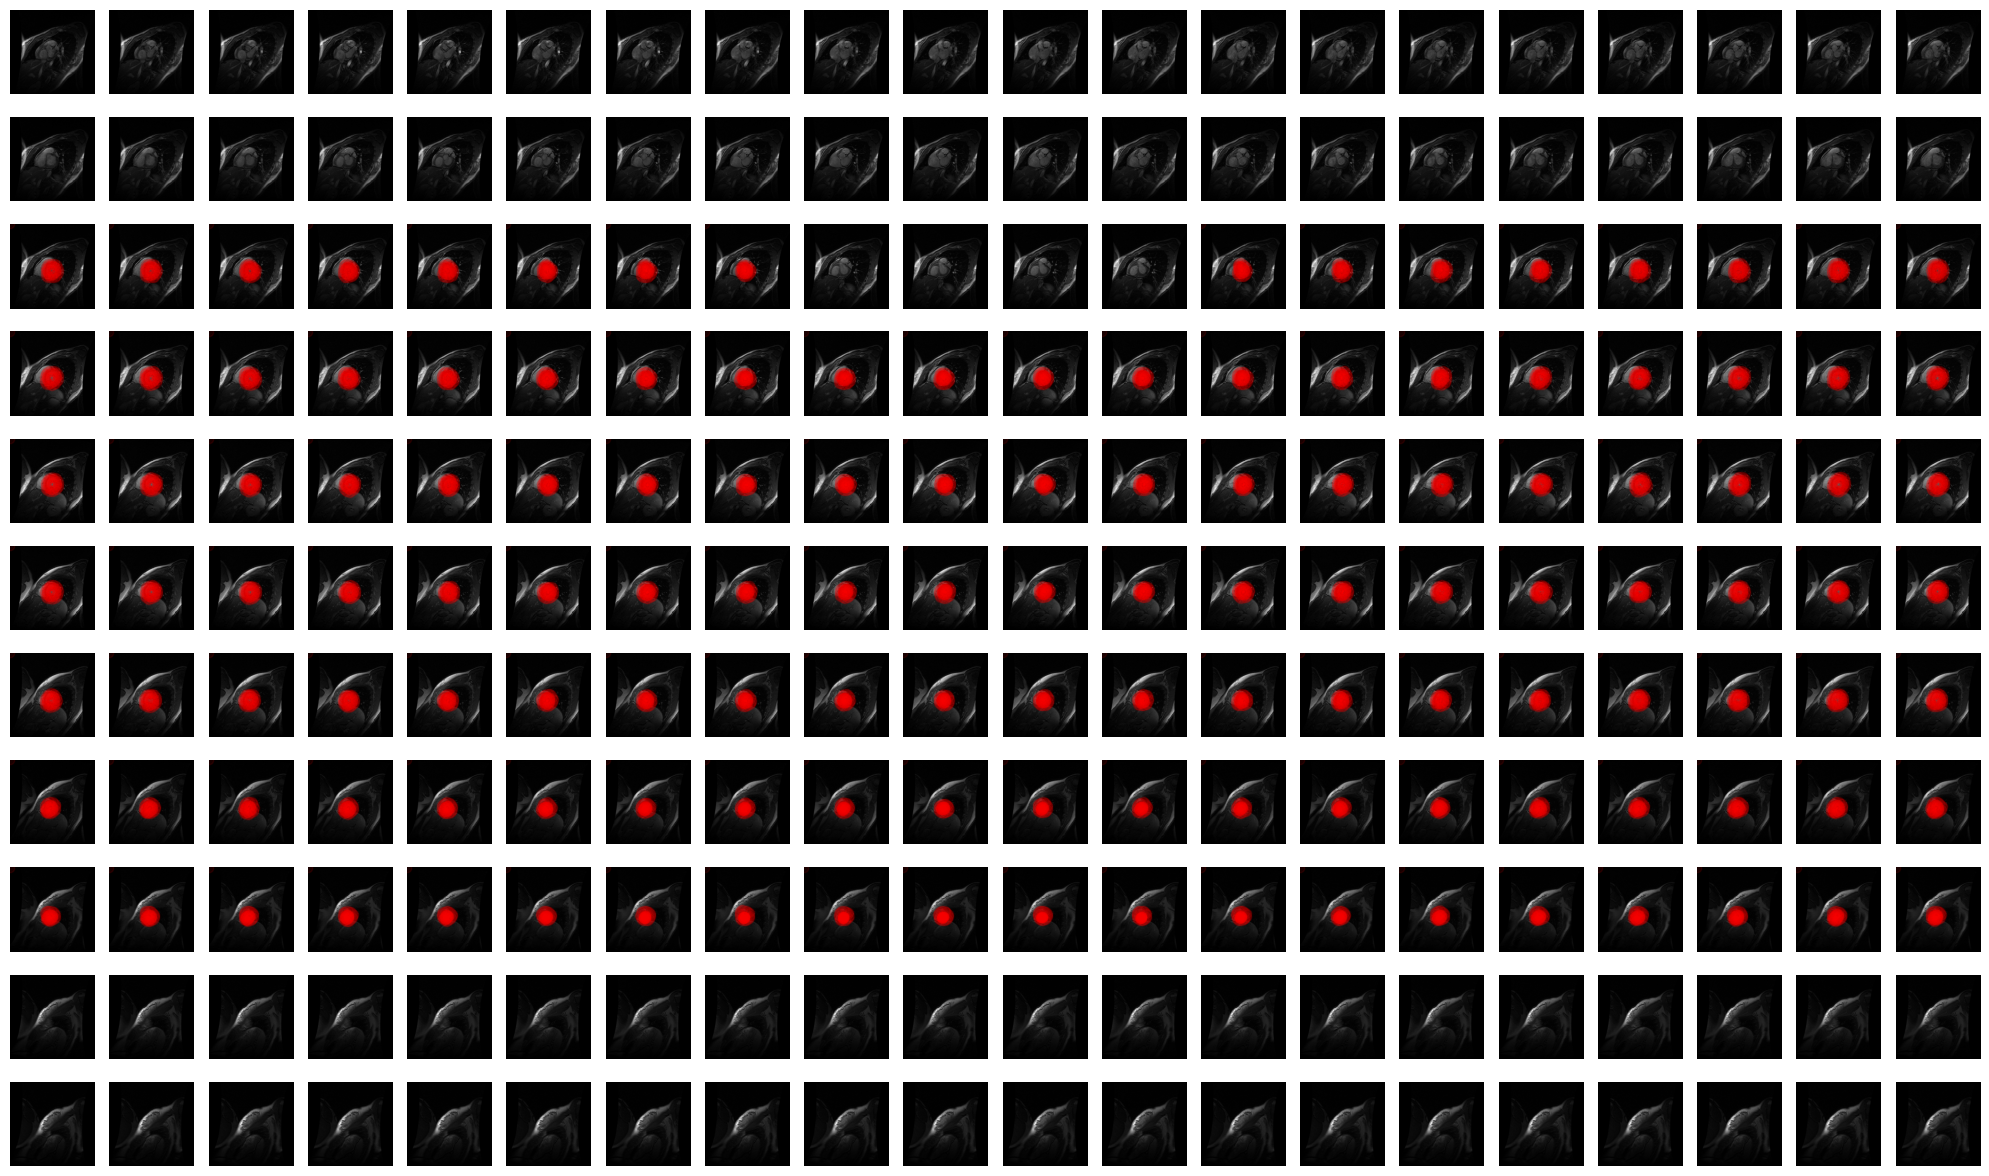

In [132]:
print(seg.shape) # (11, 20)
print(data.shape) # (256, 256, 11, 20)

# Let's plot the 11 * 20 images with the segs (array of points)
fig, axes = plt.subplots(11, 20, figsize=(20, 12))
for i in range(11):
    for j in range(20):
        axes[i,j].imshow(data[:,:,i,j], cmap='gray')
        if seg[i,j].shape[1] == 2: # Condition to avoid plotting empty segmentations (2 is necessary for valid 2d points)
            axes[i,j].scatter(seg[i,j][:,0], seg[i,j][:,1], c='r',alpha=0.1)
        axes[i,j].axis('off')
plt.tight_layout()
plt.show()

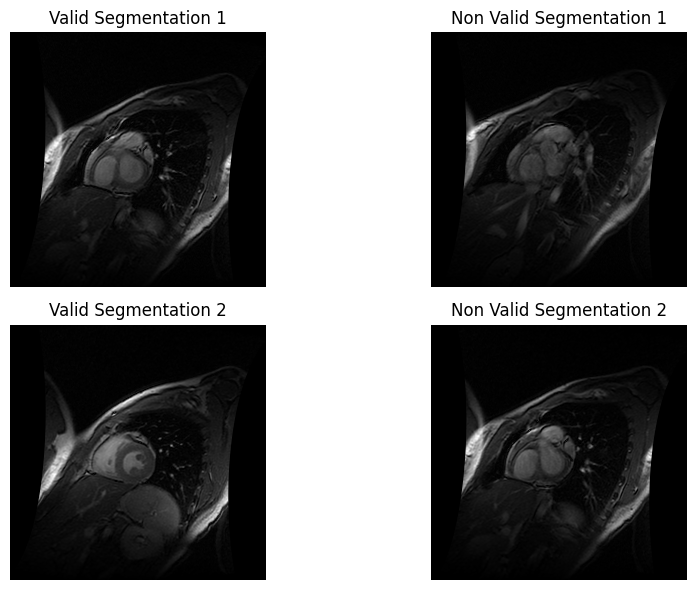

In [133]:
# Let's pick 2 valid segmentations and 2 unvalid to visualize if there is a difference
valid = [(2, 6), (4, 7)]
non_valid = [(0, 0), (2, 9)]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i, (a, b) in enumerate(valid):
    axes[i,0].imshow(data[:,:,a,b], cmap='gray')
    #axes[i,0].scatter(seg[a,b][:,0], seg[a,b][:,1], c='r',alpha=0.1)
    axes[i,0].axis('off')
    axes[i,0].set_title(f'Valid Segmentation {i+1}')

for i, (a, b) in enumerate(non_valid):
    axes[i,1].imshow(data[:,:,a,b], cmap='gray')
    axes[i,1].axis('off')
    axes[i,1].set_title(f'Non Valid Segmentation {i+1}')

plt.tight_layout()
plt.show()

There is no obvious difference. It seems like it is only some missing data. Let's deal with it:

(we simply keep the 6 patients with a ground truth for every timestep, we get 20 frames per patient)

In [134]:
# For now, let's focus on a currated dataset consisting of the 6 images with valid segmentations at every layer at every time point (patient 3 -> 8)

data_valid = data[:,:,3:9,:]
print(data_valid.shape) # (256, 256, 6, 20)

seg_valid = seg[3:9,:]
print(seg_valid.shape) # (6, 20)

(256, 256, 6, 20)
(6, 20)


The point based ground truth is hard to deal with. Let's try to convert it to a proper mask.

Timestep 6


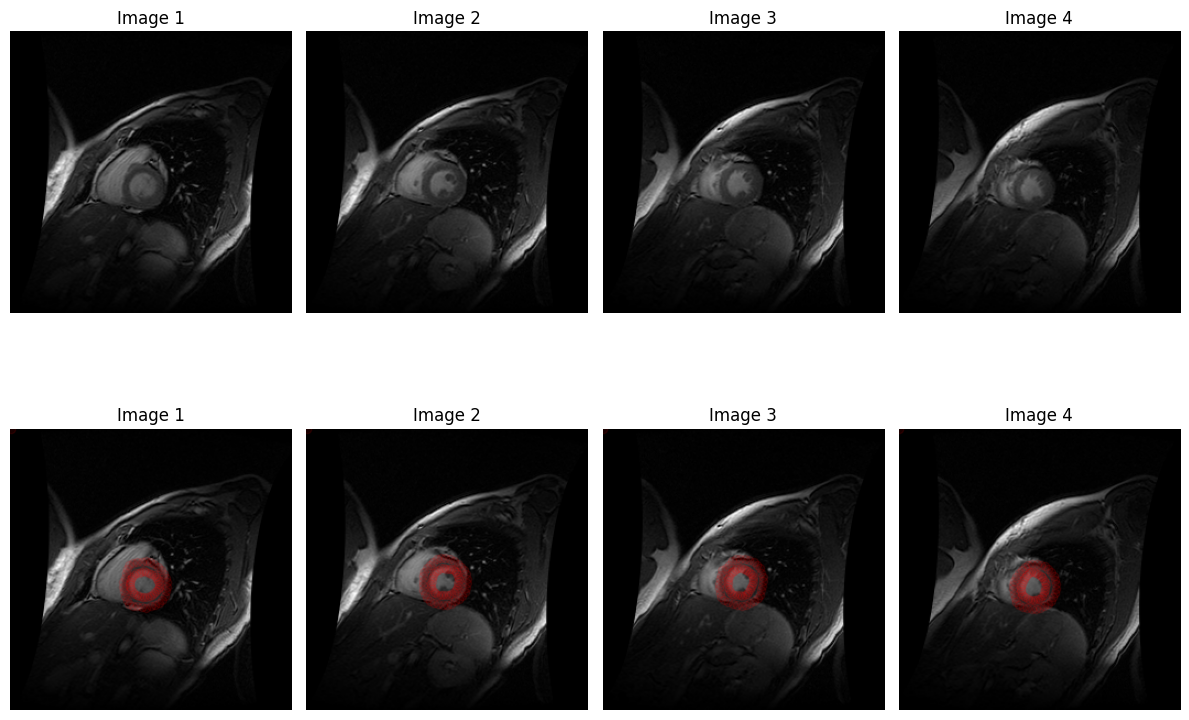

In [135]:
# Let's visualize a few ground truth (4 from 4 images), first line without gt, second line with gt

timestep = random.randint(0, 19)
print(f"Timestep {timestep}")

fig, axes = plt.subplots(2, 4, figsize=(12, 9))
for j in range(4):
    axes[0,j].imshow(data_valid[:,:,j,timestep], cmap='gray')
    axes[0,j].axis('off')
    axes[0,j].set_title(f'Image {j+1}')

    axes[1,j].imshow(data_valid[:,:,j,timestep], cmap='gray')
    axes[1,j].scatter(seg_valid[j,timestep][:,0], seg_valid[j,timestep][:,1], c='r',alpha=0.1)
    axes[1,j].axis('off')
    axes[1,j].set_title(f'Image {j+1}')

plt.tight_layout()
plt.show()


It's hard to see what's going on. Let's zoom and annotate the points.

Patient 5, Timestep 17


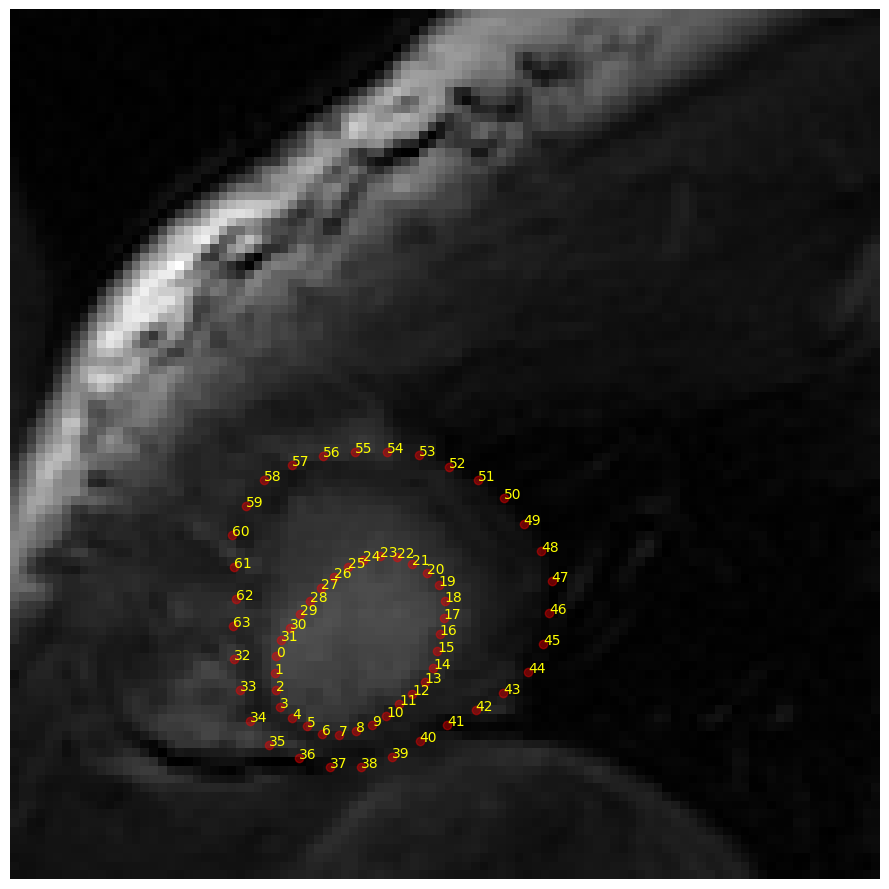

In [136]:
# Let's plot a single example in really big and HD.
patient = random.randint(0, 5)
timestep = random.randint(0, 19)
print(f"Patient {patient}, Timestep {timestep}")

fig, ax = plt.subplots(1, 1, figsize=(12, 9))

start_x = 78
start_y = 78
cropped_image = data_valid[start_x:start_x+100, start_y:start_y+100, patient, timestep]
ax.imshow(cropped_image, cmap='gray')
cropped_seg = seg_valid[patient, timestep]
cropped_seg = cropped_seg[(cropped_seg[:, 0] >= start_x) & (cropped_seg[:, 0] < start_x + 100) & 
                          (cropped_seg[:, 1] >= start_y) & (cropped_seg[:, 1] < start_y + 100)]
ax.scatter(cropped_seg[:, 0] - start_x, cropped_seg[:, 1] - start_y, c='r', alpha=0.4)

# Annotate points in order
for i, (x, y) in enumerate(cropped_seg):
    ax.annotate(str(i), (x - start_x, y - start_y), color='yellow')

ax.axis('off')
plt.tight_layout()
plt.show()

In [137]:
# Print the number of points in each segmentation
n_points = []
for patient in range(6):
    for timestep in range(20):
        n_points.append(seg_valid[patient, timestep].shape[0])
print(set(n_points))

{65}


It seems there are two segmentations: one on the epicardium and one on the endocardium. I would like to isolate the two.

Fortunately, it seems the order of the points is consistent: the inner points are annotated before the outer points.

In fact, it seems all segmentated images (when plotting all of them) have exactly the same number of points (65) and the first 31 correspond to the endocardium.

For now, let's isolate the two sets and use splines to interpolate the points.


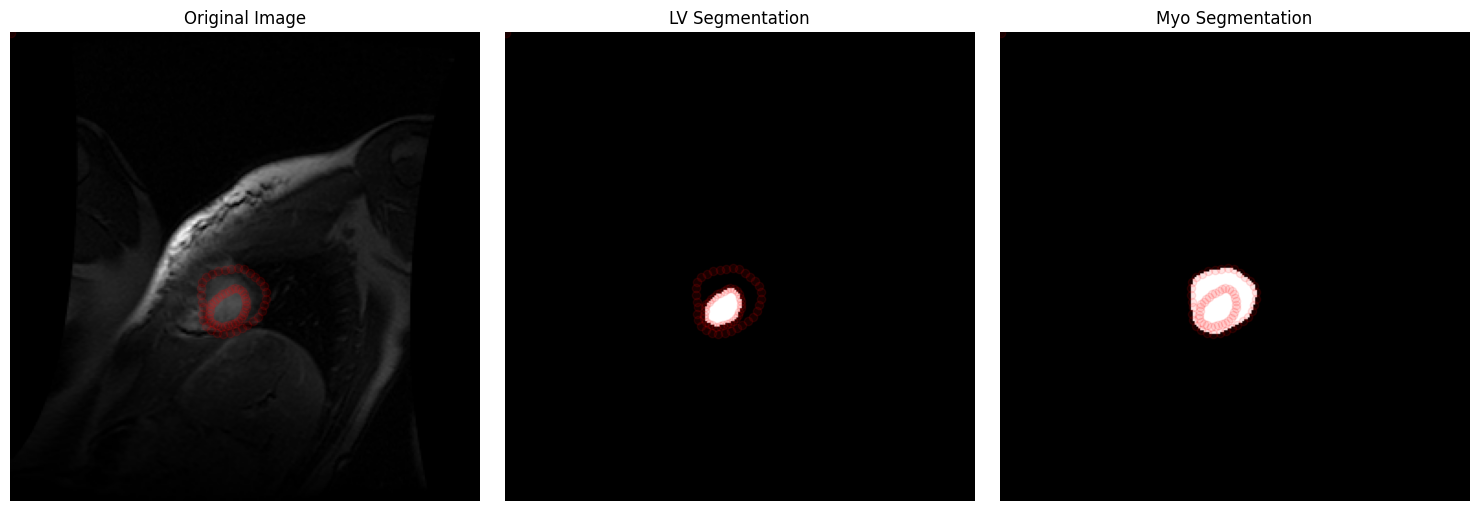

In [138]:
endo_gt = np.zeros_like(data_valid)
epi_gt = np.zeros_like(data_valid)

for p in range(6):
    for t in range(20):
        lv_seg = np.zeros((256, 256))
        myo_seg = np.zeros((256, 256))

        lv_points = seg_valid[p, t][0:32]
        myo_points = seg_valid[p, t][33:63]

        # Fill the inner points for LV segmentation
        rr, cc = polygon(lv_points[:, 1], lv_points[:, 0])
        lv_seg[rr, cc] = 1

        # Fill the inner points for Myo segmentation
        rr, cc = polygon(myo_points[:, 1], myo_points[:, 0])
        myo_seg[rr, cc] = 1

        endo_gt[:, :, p, t] = lv_seg
        epi_gt[:, :, p, t] = myo_seg

# Show the result for the first patient and timestep
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data_valid[:,:,patient,timestep], cmap='gray')
axes[0].scatter(seg_valid[patient,timestep][:,0], seg_valid[patient,timestep][:,1], c='r',alpha=0.1)
axes[0].set_title('Original Image')

axes[1].imshow(lv_seg, cmap='gray')
axes[1].scatter(seg_valid[patient,timestep][:,0], seg_valid[patient,timestep][:,1], c='r',alpha=0.1)
axes[1].set_title('LV Segmentation')

axes[2].imshow(myo_seg, cmap='gray')
axes[2].scatter(seg_valid[patient,timestep][:,0], seg_valid[patient,timestep][:,1], c='r',alpha=0.1)
axes[2].set_title('Myo Segmentation')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

We know have:
- data_valid : patients with gt
- endo_gt : endocardium ground truth (lv)
- epi_gt : epicardium ground truth (lv + myo)

Note that if needed, epi_gt minus endo_gt would give the myocardium.

Patient 3, Timestep 7


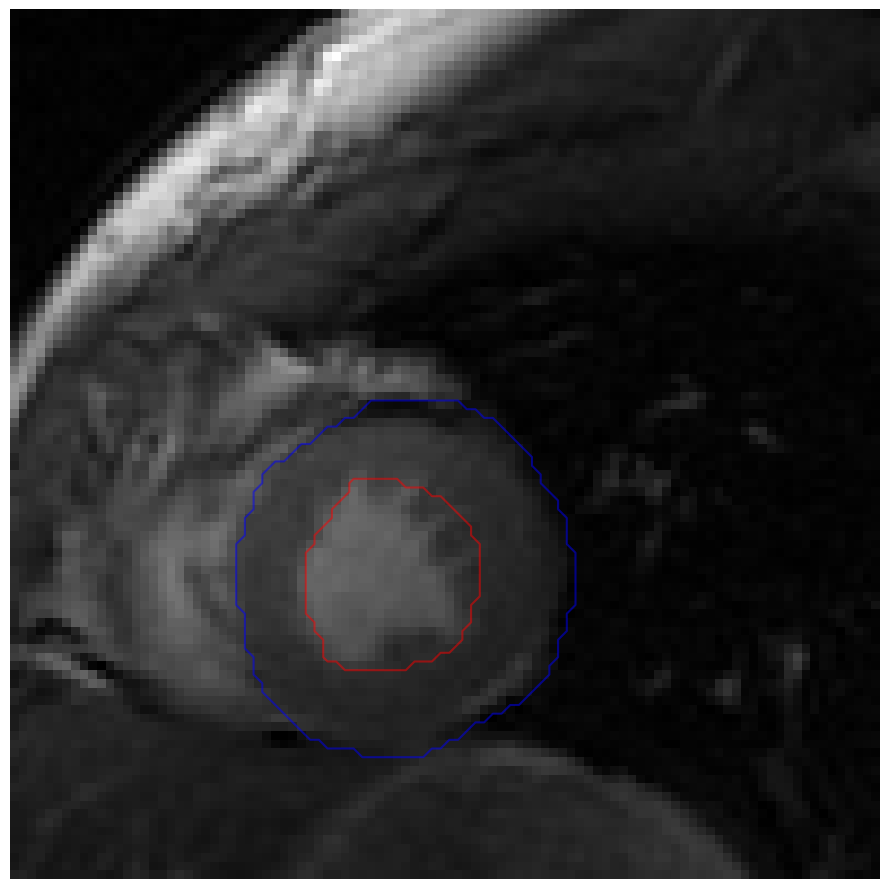

In [139]:
# Let's plot a single example in really big and HD.
patient = random.randint(0, 5)
timestep = random.randint(0, 19)
print(f"Patient {patient}, Timestep {timestep}")

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
cropped_image = data_valid[start_x:start_x+100, start_y:start_y+100, patient, timestep]
ax.imshow(cropped_image, cmap='gray')

cropped_endo_gt = endo_gt[start_x:start_x+100, start_y:start_y+100, patient, timestep]
cropped_epi_gt = epi_gt[start_x:start_x+100, start_y:start_y+100, patient, timestep]

# Add as contour
ax.contour(cropped_endo_gt, levels=[0.5], colors='r', alpha=0.5)
ax.contour(cropped_epi_gt, levels=[0.5], colors='b', alpha=0.5)

ax.axis('off')
plt.tight_layout()
plt.show()

In [140]:
# Let's analyse the distribution of lv mask size
lv_sizes = []
for p in range(6):
    for t in range(20):
        lv_sizes.append(np.sum(endo_gt[:,:,p,t]))
print(np.mean(lv_sizes), np.std(lv_sizes))
print(np.min(lv_sizes), np.max(lv_sizes))

511.14166666666665 253.5463894383476
43 959


---
# Segmentation pipeline

Let's now proceed with the segmentation.

After many iterations, we get the following pipeline:
Below is a concise and clear Markdown explanation of the segmentation pipeline and its hyperparameters:

---
### Hyperparameters
- **MIN_K (2) & MAX_K (6):**  
  Defines the range for the number of clusters in the adaptive k-means clustering.

- **HOLE_FILL_AREA_THRESHOLD (100):**  
  Sets the maximum area of holes to fill in the morphological processing step.

- **MEDIAN_CLOSING_DISK_SIZE (1):**  
  Specifies the disk size for the binary closing operation, helping to remove small gaps.

- **NOISE_AREA_THRESHOLD (50) & DICE_THRESHOLD (0.5):**  
  Defined for potential future use in noise filtering and segmentation quality assessment.


### Pipeline Overview
0. **Preprocessing**  
   - We only keep the middle 100 pixels of the image to remove the background.

1. **Adaptive k-means Clustering**  
   - **Normalization:** The image is reshaped and normalized to a [0, 1] range.  
   - **Clustering:** For k values between MIN_K (2) and MAX_K (6), MiniBatchKMeans is applied and the silhouette score evaluated. The best k is selected to cluster the image.

2. **Morphological Processing**  
   - **Hole Filling:** Small holes (area < HOLE_FILL_AREA_THRESHOLD, 100) in the clustered mask are filled.
   - **Local Otsu Thresholding:** A local threshold (block size 35) is computed to create a binary mask.
   - **Binary Closing:** A binary closing using a disk of size MEDIAN_CLOSING_DISK_SIZE (1) removes residual noise.

3. **Connected Component Analysis**  
   - The refined binary mask is labeled with connected component analysis using OpenCV.

4. **Heuristic Region Selection**  
   - Regions are evaluated based on area, eccentricity, and distance from the image center.
   - Regions with areas outside acceptable bounds (e.g., MIN_SIZE and MAX_SIZE) are penalized.
   - The region with the best (lowest) heuristic score is chosen as the left ventricle.

5. **Boundary Detection and Visualization**  
   - The contour of the selected region is extracted.
   - Optional debug mode plots each processing step and overlays the segmentation boundary (and ground truth if provided).

6. **Dice Coefficient Calculation**  
   - The `calculate_dice` function computes the overlap between the segmented result and the ground truth to evaluate segmentation quality.
---



In [141]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage import morphology, filters, measure, segmentation
from skimage.draw import polygon
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import cv2
import random
from tqdm import tqdm

# -------------------- Hyperparameters --------------------
MIN_K = 2
MAX_K = 6
HOLE_FILL_AREA_THRESHOLD = 100
MEDIAN_CLOSING_DISK_SIZE = 1
NOISE_AREA_THRESHOLD = 50
DICE_THRESHOLD = 0.5
# ----------------------------------------------------------

# -------------------- Segmentation Functions --------------------

def adaptive_k_means(image, min_k=MIN_K, max_k=MAX_K):
    # Normalize the image
    pixels = image.reshape(-1, 1).astype(np.float32)
    pixels_normalized = (pixels - np.min(pixels)) / (np.max(pixels) - np.min(pixels))
    
    best_score = -1
    best_k = min_k
    #for k in tqdm(range(min_k, max_k + 1)):
    for k in range(min_k, max_k + 1):
        mb_km = MiniBatchKMeans(n_clusters=k, batch_size=1000, max_iter=100, n_init=10, random_state=42)
        mb_km.fit(pixels_normalized)
        labels = mb_km.labels_
        if k > 1:
            score = silhouette_score(pixels_normalized, labels)
        else:
            score = 0
        if score > best_score:
            best_score = score
            best_k = k

    # Final clustering with the best k
    final_km = MiniBatchKMeans(n_clusters=best_k, batch_size=1000, max_iter=100, n_init=10, random_state=42)
    final_km.fit(pixels_normalized)
    clustered_image = final_km.labels_.reshape(image.shape)
    return clustered_image

def segment_left_ventricle(image, gt=None, debug=False):
    # 1. Adaptive k-means
    clustered = adaptive_k_means(image)
    
    # 2. Morphological hole fill
    filled = morphology.remove_small_holes(clustered.astype(bool), area_threshold=HOLE_FILL_AREA_THRESHOLD).astype(np.uint8)
    
    # 3. Local Otsu threshold
    local_thresh = filters.threshold_local(filled, block_size=35)
    thresh_img = (filled > local_thresh).astype(bool)
        
    # 4. Remove small holes
    median_filled = morphology.binary_closing((1 - thresh_img), footprint=morphology.disk(MEDIAN_CLOSING_DISK_SIZE)).astype(np.uint8)
    median_filled = (1 - median_filled).astype(np.uint8)

    # Label the connected components using cv2
    unique_vals = [val for val in np.unique(median_filled)]
    components = {}
    labeled = np.zeros_like(median_filled, dtype=np.uint8)
    current_label = 0
    for val in unique_vals:
        mask = (median_filled == val).astype(np.uint8)
        num_labels, labels = cv2.connectedComponents(mask, connectivity=8)
        if debug: print(f"Number of connected components for value {val}: {num_labels}")
        labels = labels.astype(np.uint8)
        labels[labels != 0] += current_label
        components[val] = (num_labels, labels)
        labeled += labels
        current_label += num_labels

    # Normalize the labeled image
    labeled = (labeled / np.max(labeled) * 255).astype(np.uint8)

    # 6. Heuristic selection
    MAX_SIZE = 5000
    MIN_SIZE = 300
    refined_label = 0
    best_score = float('inf')
    rows, cols = image.shape[:2]
    center = np.array([rows/2, cols/2])
    for prop in measure.regionprops(labeled):
        dist = np.linalg.norm(np.array(prop.centroid) - center)
        score = 3 * prop.eccentricity + dist
        if prop.area > MAX_SIZE or prop.area < MIN_SIZE:
            score = float('inf')
        if debug: print(f"Area: {np.round(prop.area, 2)}, Eccentricity: {np.round(prop.eccentricity, 2)}, Centroid: {np.round(prop.centroid, 2)}, Score: {np.round(score)}")

        if score < best_score:
            if debug: print(f"New best score: {score}")
            best_score = score
            refined_label = prop.label

    lv_mask = (labeled == refined_label).astype(np.uint8)
    
    # 7. Boundary detection
    contours, _ = cv2.findContours(lv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary = contours[0] if contours else None

    if debug:
        # Let's plot original, clustered, filled, otsued, median_filtered and the final mask.
        fig, axes = plt.subplots(2, 3, figsize=(18, 9))
        axes[0, 0].imshow(image, cmap='gray')
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(clustered, cmap='gray')
        axes[0, 1].set_title('Clustered Image')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(filled, cmap='gray')
        axes[0, 2].set_title('Filled Image')
        axes[0, 2].axis('off')

        axes[1, 0].imshow(thresh_img, cmap='gray')
        axes[1, 0].set_title('Otsu Threshold')
        axes[1, 0].axis('off')

        # Show the bar of values
        axes[1, 1].imshow(labeled, cmap='gray') 
        axes[1, 1].set_title('Median Filled')

        axes[1, 2].imshow(lv_mask, cmap='gray')
        if boundary is not None:
            axes[1, 2].plot(boundary[:, 0, 0], boundary[:, 0, 1], 'r', alpha=0.5)
        if gt is not None:
            axes[1, 2].contour(gt, levels=[0.5], colors='b', alpha=0.5)
        axes[1, 2].set_title('Final Mask')
        axes[1, 2].axis('off')

        plt.tight_layout()
        plt.show()
    
    return lv_mask, boundary

def calculate_dice(seg, gt):
    intersection = np.sum((seg == 1) & (gt == 1))
    dice = (2. * intersection) / (np.sum(seg) + np.sum(gt))
    return dice

Let's run the pipeline on an example, showing the intermediate steps and the final segmentation result. (rerun the cell to see the results on a different example)

Patient 3, Timestep 18
Number of connected components for value 0: 3
Number of connected components for value 1: 5
Area: 625.0, Eccentricity: 0.84, Centroid: [11.43 11.22], Score: 57.0
New best score: 57.22126911542227
Area: 7395.0, Eccentricity: 0.59, Centroid: [53.76 57.6 ], Score: inf
Area: 710.0, Eccentricity: 0.98, Centroid: [15.52 28.89], Score: 43.0
New best score: 43.361821443471364
Area: 516.0, Eccentricity: 0.92, Centroid: [62.2  19.01], Score: 36.0
New best score: 36.05549431864962
Area: 5.0, Eccentricity: 0.0, Centroid: [44. 10.], Score: inf
Area: 749.0, Eccentricity: 0.47, Centroid: [62.71 42.3 ], Score: 16.0
New best score: 16.264327774822675


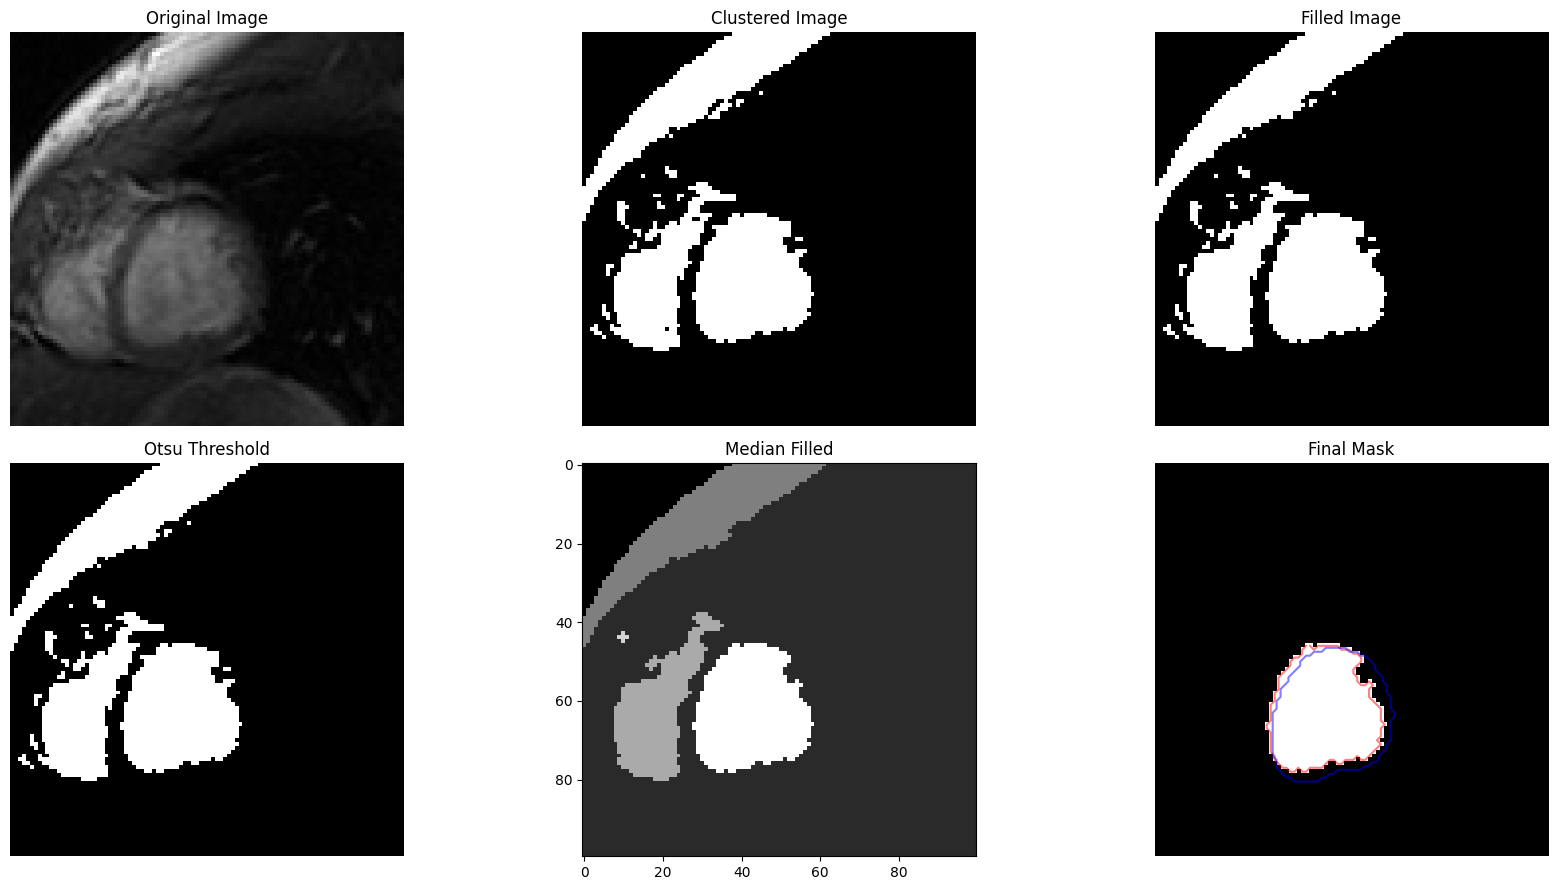

Dice: 0.8746803069053708


In [145]:
patient = random.randint(0, 5)
timestep = random.randint(0, 19)
print(f"Patient {patient}, Timestep {timestep}")

image = data_valid[:,:,patient,timestep]
endo_gt_image = endo_gt[:,:,patient,timestep]

zoomed_image = image[78:178, 78:178]
zoomed_gt = endo_gt_image[78:178, 78:178]

lv_mask, boundary = segment_left_ventricle(zoomed_image, zoomed_gt, debug=True)

dice = calculate_dice(lv_mask, zoomed_gt)
print(f"Dice: {dice}")

# Results and analysis

Let's run the pipeline on all the examples and compute the Dice coefficient for each segmentation.

We then plot the histograms of the Dice coefficients to evaluate the quality of the pipeline. **This is my main evaluation result.**

Finally, we visualize the segmentation results on two of the better examples (two different patients and timesteps) to answer the goal of this TP 

>*Choosing the 2 images after the two images is very biased, but at less the result is pretty :)*

100%|██████████| 120/120 [26:20<00:00, 13.17s/it]

Average Dice Score: 0.44, Std: 0.34


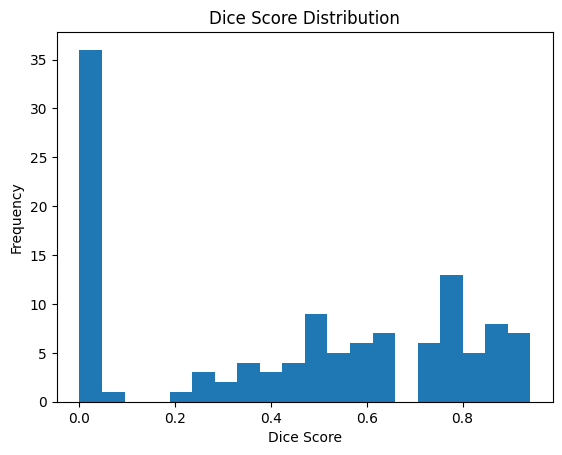

In [142]:
# Let's evaluate on all patients and then create an histogram of the dice scores
dice_scores = []

for id in tqdm(range(6 * 20)):
    patient = id // 20
    timestep = id % 20
    image = data_valid[:,:,patient,timestep]
    gt = endo_gt[:,:,patient,timestep]

    # Keep middle 100x100 region
    start_x = 78
    start_y = 78
    image = image[start_x:start_x+100, start_y:start_y+100]
    gt = gt[start_x:start_x+100, start_y:start_y+100]
    
    # Segment
    seg_pred, boundary = segment_left_ventricle(image, gt)
    
    # Calculate Dice score
    dice = calculate_dice(seg_pred, gt)
    dice_scores.append(dice)

print(f"Average Dice Score: {np.mean(dice_scores):.2f}, Std: {np.std(dice_scores):.2f}")

# Plot the histogram
plt.hist(dice_scores, bins=20)
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.title('Dice Score Distribution')
plt.show()

In [143]:
# Show the indices for the 10 best and 10 worst segmentations
dice_scores = np.array(dice_scores)
best_indices = np.argsort(dice_scores)[-10:][::-1]
worst_indices = np.argsort(dice_scores)[:10]

print("Best Indices")
for idx in best_indices:
    print(f"Patient {idx // 20}, Timestep {idx % 20}, Dice Score: {dice_scores[idx]:.2f}")
print("...")
print("Worst Indices")
for idx in worst_indices:
    print(f"Patient {idx // 20}, Timestep {idx % 20}, Dice Score: {dice_scores[idx]:.2f}")

Best Indices
Patient 0, Timestep 0, Dice Score: 0.94
Patient 0, Timestep 19, Dice Score: 0.93
Patient 0, Timestep 1, Dice Score: 0.93
Patient 0, Timestep 2, Dice Score: 0.92
Patient 0, Timestep 10, Dice Score: 0.91
Patient 0, Timestep 3, Dice Score: 0.90
Patient 0, Timestep 4, Dice Score: 0.90
Patient 0, Timestep 5, Dice Score: 0.89
Patient 3, Timestep 16, Dice Score: 0.89
Patient 3, Timestep 18, Dice Score: 0.87
...
Worst Indices
Patient 2, Timestep 8, Dice Score: 0.00
Patient 5, Timestep 2, Dice Score: 0.00
Patient 5, Timestep 1, Dice Score: 0.00
Patient 5, Timestep 0, Dice Score: 0.00
Patient 5, Timestep 7, Dice Score: 0.00
Patient 5, Timestep 6, Dice Score: 0.00
Patient 5, Timestep 5, Dice Score: 0.00
Patient 5, Timestep 4, Dice Score: 0.00
Patient 5, Timestep 8, Dice Score: 0.00
Patient 5, Timestep 9, Dice Score: 0.00


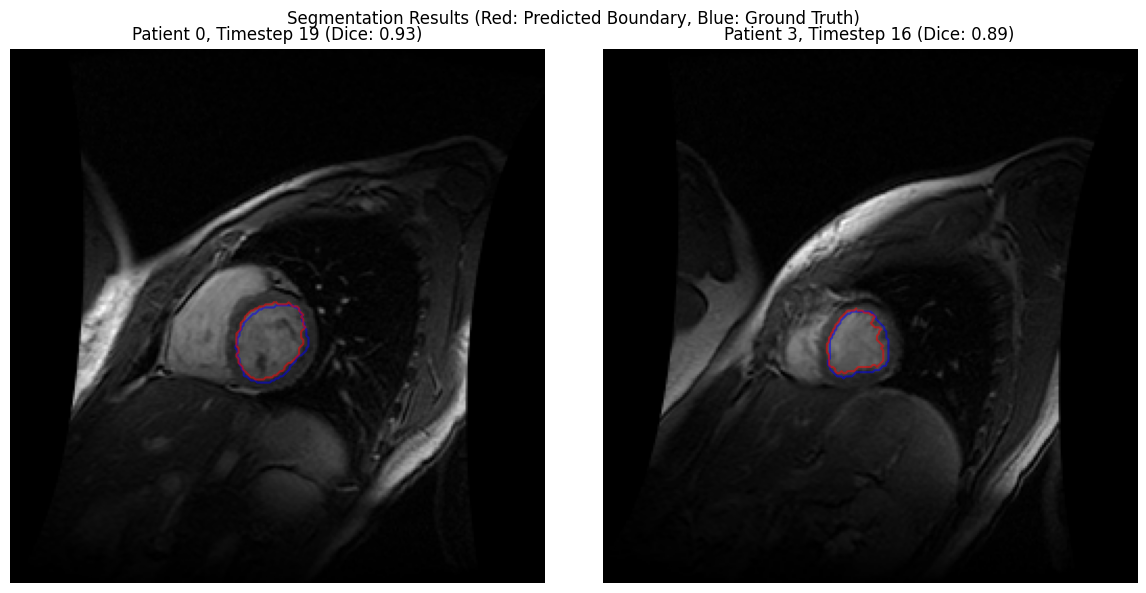

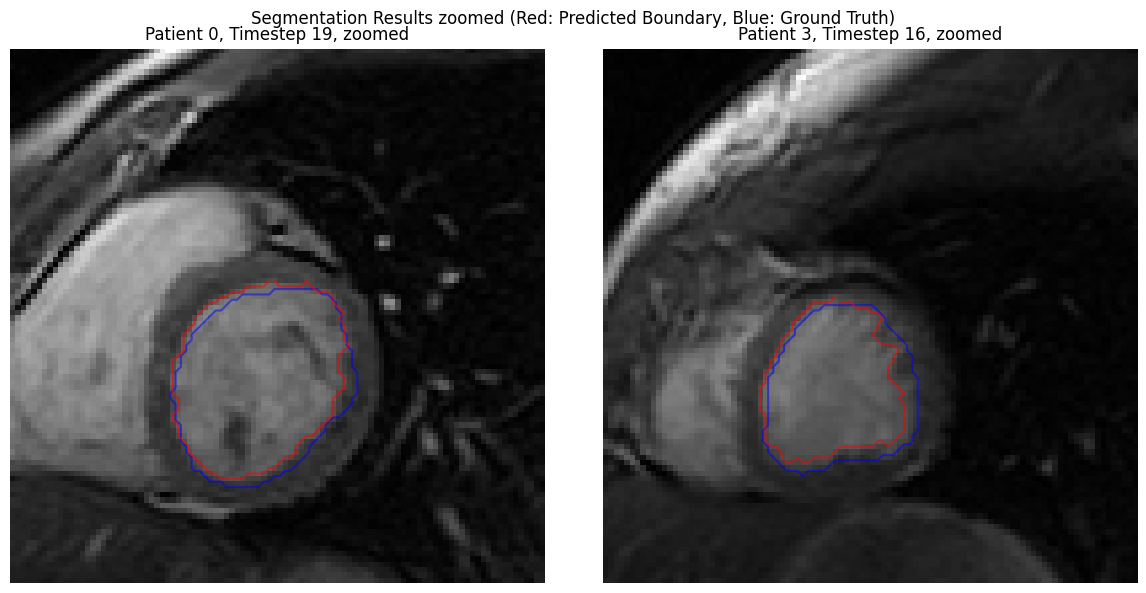

In [144]:
# Let's take a look at patient 0, timestep 19 and at patient 3, timestep 16
patient1, timestep1 = 0, 19
image1 = data_valid[:,:,patient1,timestep1]
gt1 = endo_gt[:,:,patient1,timestep1]
zoomed_im1 = image1[78:178, 78:178]
zoomed_gt1 = gt1[78:178, 78:178]

patient2, timestep2 = 3, 16
image2 = data_valid[:,:,patient2,timestep2]
gt2 = endo_gt[:,:,patient2,timestep2]
zoomed_im2 = image2[78:178, 78:178]
zoomed_gt2 = gt2[78:178, 78:178]

# Segment
zoomed_seg_pred1, zoomed_boundary1 = segment_left_ventricle(zoomed_im1, zoomed_gt1)
zoomed_seg_pred2, zoomed_boundary2 = segment_left_ventricle(zoomed_im2, zoomed_gt2)

boundary1 = zoomed_boundary1 + np.array([78, 78])
boundary2 = zoomed_boundary2 + np.array([78, 78])

dice1 = calculate_dice(zoomed_seg_pred1, zoomed_gt1)
dice2 = calculate_dice(zoomed_seg_pred2, zoomed_gt2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image and the zoomed one (both with the ground truth)
axes[0].imshow(image1, cmap='gray')
axes[0].contour(gt1, levels=[0.5], colors='b', alpha=0.5)
axes[0].plot(boundary1[:, 0, 0], boundary1[:, 0, 1], 'r', alpha=0.5)
axes[0].set_title(f'Patient 0, Timestep 19 (Dice: {dice1:.2f})')
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].contour(gt2, levels=[0.5], colors='b', alpha=0.5)
axes[1].plot(boundary2[:, 0, 0], boundary2[:, 0, 1], 'r', alpha=0.5)
axes[1].set_title(f"Patient 3, Timestep 16 (Dice: {dice2:.2f})")
axes[1].axis('off')

plt.suptitle('Segmentation Results (Red: Predicted Boundary, Blue: Ground Truth)')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(zoomed_im1, cmap='gray')
axes[0].contour(zoomed_gt1, levels=[0.5], colors='b', alpha=0.5)
axes[0].plot(zoomed_boundary1[:, 0, 0], zoomed_boundary1[:, 0, 1], 'r', alpha=0.5)
axes[0].set_title(f'Patient 0, Timestep 19, zoomed')
axes[0].axis('off')

axes[1].imshow(zoomed_im2, cmap='gray')
axes[1].contour(zoomed_gt2, levels=[0.5], colors='b', alpha=0.5)
axes[1].plot(zoomed_boundary2[:, 0, 0], zoomed_boundary2[:, 0, 1], 'r', alpha=0.5)
axes[1].set_title(f"Patient 3, Timestep 16, zoomed")
axes[1].axis('off')

plt.suptitle('Segmentation Results zoomed (Red: Predicted Boundary, Blue: Ground Truth)')

plt.tight_layout()
plt.show()

# Conclusion

The segmentation that I now have is quite poor (as seen in the **Dice score histogram**). While it is able to detect the left ventricle on a few examples, in most of them it fails to do so.

I could add a lot of meaningful visualization, like examples of good and bad segmentations, but I chose not to include them in the final notebook as it is already quite long.

For this TP, I wanted to use K-Means (or in this case adaptative K-Means) to segment the left ventricle. I think I still struggle to create a good pipeline around it. 

To further improve my pipeline, I would first consider the following points:

- **Improve adaptative K-Means:** While I say I use adaptative K-Means, I actually mainly end up using 2 clusters. I think this is because I use the default silhouette score to select the best number of clusters, which does not make that much sense here. I should probably use a different metric or a different approach to select the best number of clusters.
- **Multi-temporal consistency:** The segmentation should be consistent across time frames for a given patient. This could be achieved by using the temporal information to guide the segmentation process.